## Practical VDL class session for Hidden Markov Models: forward, Viterbi & Baum-Walch algorithms


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random as random
import pandas as pd
random.seed(42)

### Question 1 : simulation d’un HMM


In [2]:
def SimuHMMdisc(n, param):

    nu = np.array(param['pi'])
   
    B= np.array(param['B'])
    A= np.array(param['A']) 

    z = np.zeros(n, dtype=int)
    x = np.zeros(n, dtype=int)
    
    #sample first hidden state and first observation
    z[0] = np.random.choice(len(nu), p = nu) 
    print(z)
    x[0] = np.random.choice(len(B[z[0]]), p=B[z[0]])
    print(x)
 
    for i in range(1,n):
        z[i]= np.random.choice( len(nu), p=A[z[i-1]])
        print(z)
        x[i] = np.random.choice(len(B[z[i]]), p= B[z[i]])
        print(x)

  
    sequence = list(zip(x, z))
    
    return sequence 


In [3]:
n = int(10)

In [4]:
# Transition Matrix A for the hidden states
A = np.array([
    [0.95, 0.05],
    [0.10, 0.90]
])

# Emission Matrix B
# Rows correspond to hidden states, columns to observable outcomes
# B = np.transpose(np.array([
#     [1/6]*6 + [1/10]*5 + [0.5],
#     [1/6]*6 + [1/10]*5 + [0.5]
# ])).reshape(6, 2)
B = np.array([
    [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],  # Uniform distribution over 6 outcomes for state 0
    [1/10, 1/10, 1/10, 1/10, 1/10, 0.5]  # Different distribution for state 1
])

eigenvalues, eigenvectors = np.linalg.eig(A.T)
pi_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]
pi_real = np.real(pi_vector)
pi = pi_real / np.sum(pi_real)

params = {
    'A': A,
    'B': B,
    'pi': pi.flatten()  
}
params


{'A': array([[0.95, 0.05],
        [0.1 , 0.9 ]]),
 'B': array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667],
        [0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
         0.5       ]]),
 'pi': array([0.66666667, 0.33333333])}

In [5]:
seq = SimuHMMdisc(n, params)
seq

[0 0 0 0 0 0 0 0 0 0]
[5 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[5 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[5 0 4 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[5 0 4 2 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0]
[5 0 4 2 5 0 0 0 0 0]
[0 0 0 0 1 1 0 0 0 0]
[5 0 4 2 5 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 0]
[5 0 4 2 5 0 5 0 0 0]
[0 0 0 0 1 1 1 0 0 0]
[5 0 4 2 5 0 5 5 0 0]
[0 0 0 0 1 1 1 0 0 0]
[5 0 4 2 5 0 5 5 4 0]
[0 0 0 0 1 1 1 0 0 0]
[5 0 4 2 5 0 5 5 4 2]


[(5, 0),
 (0, 0),
 (4, 0),
 (2, 0),
 (5, 1),
 (0, 1),
 (5, 1),
 (5, 0),
 (4, 0),
 (2, 0)]

range(0, 10)


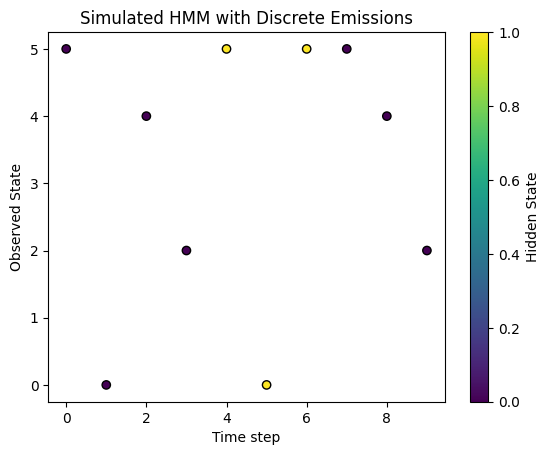

In [6]:
x, z = zip(*seq)
x, z = list(x), list(z)
plt.scatter(range(n), x, c=z, cmap='viridis', edgecolors='k')
print(range(n))
plt.colorbar(label='Hidden State')
plt.xlabel('Time step')
plt.ylabel('Observed State')
plt.title('Simulated HMM with Discrete Emissions')
plt.show()

### Question 2. calcul de la vraisemblance - l’algorithme forward


In [7]:
print(math.exp(-100001))

#avoid overflowing part
def log_sum_exp(x):
    x_max = np.max(x)
    return x_max + np.log(np.sum(np.exp(x - x_max)))

log_sum_exp([-100000, -100001, -100002])

0.0


-99999.59239403556

In [8]:
# K = 4
# nexp = 100  
# mus = np.linspace(0, -1000, nexp) 
# res = pd.DataFrame({
#     'mu': mus,
#     'naive': np.nan,
#     'log_trick': np.nan
# })

# for i in range(len(mus)):
#     a = np.random.normal(loc=mus[i], scale=20, size=K)
#     res.loc[i, 'naive'] = np.log(np.sum(np.exp(a)))
#     res.loc[i, 'log_trick'] = log_sum_exp(a)

# df = res.melt(id_vars='mu', var_name='Method', value_name='logsumexp')


# sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))
# ax = sns.scatterplot(data=df, x='mu', y='logsumexp', hue='Method', style='Method', s=100, alpha=0.7)
# plt.plot([mus.min(), mus.max()], [mus.min(), mus.max()], 'k--')  # y=x line
# plt.title('Illustration of the log-sum-exp trick')
# plt.show()



$$ \alpha_i(k) = P(observe \, sequence \, up \, until\,  time \, i \, and \, have \, hidden \, state \, at \, k)   $$ 
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K \alpha_{i-1}(l) \cdot A_{lk} \cdot \Psi_i(k) \right)
$$
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l) \cdot A_{lk})} \cdot e^{\log(\Psi_i(k))} \right)
$$
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l)) + \log(A_{lk})} \cdot e^{\log(\Psi_i(k))} \right)
$$
$$
\log(\alpha_i(k)) = \log(\Psi_i(k)) + \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l)) + \log(A_{lk})} \right)
$$

$$ init: \, \alpha_1(l) = p(x_1, z_1 = l) = \nu_l \Psi_1(l), \, \forall l$$

In [9]:
def forward(x, i, param):
    """return : log α_i s using log_trick"""
    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    log_alpha = np.full((n, K), -np.inf)
    
    for l in range(K):
        log_alpha[0, l] = np.log(nu[l]) + np.log(B[l, x[0]])

    for i in range(1,n):
        for k in range(K):
            # log_alpha_prev = np.log(log_alpha[i]) 
            exponent = log_alpha[i-1] + np.log(A[:,k])
            # print(log_alpha[i-1] )
            log_alpha[i, k] = np.log(psi[k, x[i]]) + log_sum_exp(exponent)



    # return log_alpha
    return log_alpha[i-1] 

In [10]:
logalpha_10 = forward(x, 10, params)
logalpha_10 # hidden state at time i is 2?!

array([-16.02907819, -15.58840754])

In [11]:
z[9]

0

Une fonction HMMloglik(x, param) qui calcule la log-vraisemblance de x sous un modèle HMM discret

In [12]:
def HMMloglik(x, param):
    K= np.array(param['A']).shape[0]
    sum = 0
    for k in range(K):
        sum+= forward(x, k, param)
    return np.log(sum)

In [13]:
def Viterbi(x, param):

    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    
    print(psi.shape)
    V = np.full((n, K), -np.inf)
    S = np.full((n, K), -np.inf)

   
    
    for l in range(K):
        V[0, l] = np.log(nu[l]) + np.log(psi[l, x[0]])

    for i in range(1,n):
        for k in range(K):
            # print(V[i-1,:])
            V[i, k]= psi[k, x[i]] + np.max(V[i-1,:] * np.log(A[:,k]))
            S[i,k ]= np.argmax(V[i-1,:]* np.log(A[:,k]))
    print(V, S)
    return 



    

In [14]:
Viterbi(x, params)

(2, 6)
[[-2.19722458 -1.79175947]
 [ 4.29234531  6.68229658]
 [-0.05350186 -0.60405021]
 [ 1.55754368  0.26027726]
 [ 0.08677512  0.47257705]
 [ 0.16221568  0.05020904]
 [ 0.15834609  0.49470995]
 [ 0.15854457  0.4478771 ]
 [ 0.15853439  0.05281144]
 [ 0.15853492  0.09443576]] [[-inf -inf]
 [  1.   0.]
 [  0.   1.]
 [  1.   0.]
 [  0.   1.]
 [  0.   1.]
 [  0.   1.]
 [  0.   1.]
 [  0.   1.]
 [  0.   1.]]


In [15]:
def forward_estep(x, i, param):
    """return : log α_i s using log_trick"""
    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    log_alpha = np.full((n, K), -np.inf)
    
    for l in range(K):
        log_alpha[0, l] = np.log(nu[l]) + np.log(B[l, x[0]])

    for i in range(1,n):
        for l in range(K):
            # log_alpha_prev = np.log(log_alpha[i]) 
            exponent = log_alpha[i-1] + np.log(A[:,l])
            # print(log_alpha[i-1] )
            log_alpha[i, l] = np.log(psi[l, x[i]]) + log_sum_exp(exponent)



    return log_alpha.T
  

In [16]:
forward_estep(x, 10, params)

array([[ -2.19722458,  -3.89367387,  -5.65941123,  -7.45809453,
         -9.27367897, -11.0276449 , -12.82048994, -14.51946032,
        -16.02907819, -17.72065311],
       [ -1.79175947,  -4.16333743,  -6.50105636,  -8.78775921,
         -9.39565684, -11.74273059, -12.43366213, -13.19513055,
        -15.58840754, -17.96122173]])

1. **Standard Form:**

$$
\beta_i(k) = \sum_{l=1}^{K} A[k, l] \cdot B[l, x_{i+1}] \cdot \beta_{i+1}(l)
$$

2. **Log-Space Form:**

$$
\log \beta_i(k) = \log \sum_{l=1}^{K} \exp\left(\log A[k, l] + \log B[l, x_{i+1}] + \log \beta_{i+1}(l)\right)
$$


In [17]:
def backward(x, param):
    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    log_beta = np.full((n, K), -np.inf)
    for l in range(K):
        log_beta[-1, l] = 0 #b_n(k)=1
    
    for i in range(n-2,-1, -1):
        # print(i)
        for l in range(K):
            exponent= np.log(A[l, :]) + np.log(psi[:, x[i + 1]]) + log_beta[i + 1]
            log_beta[i, l]= log_sum_exp(exponent)
    return log_beta.T

    
    
    

In [18]:
backward(x, params)

array([[-15.71124009, -13.90605029, -12.12743458, -10.40305273,
         -8.80473368,  -7.05847096,  -5.40653174,  -3.63460173,
         -1.81196218,   0.        ],
       [-15.97241738, -13.70557625, -11.38184488,  -9.019267  ,
         -8.24163032,  -5.88963219,  -5.11851441,  -4.39635096,
         -2.23804657,   0.        ]])

$$
\tau_i(k) \propto \alpha_i(k) \beta_i(k),
$$
$$
\log \tau_i(k) = \log \alpha_i(k) + \log \beta_i(k) + \text{normalization constant (log-sum-exp trick)},
$$
$$\xi_{i,i+1}(k, l) \propto \alpha_i(k) \Psi_{i+1}(l) \beta_{i+1}(l) A_{kl}.$$

In [19]:
def estep(x, param):
    A= np.array(param['A'])
    K= len(A)
    n= len(x)
    log_alphas= forward_estep(x,n, param)
    log_betas= backward(x, param)
    psi= np.array(param['B'])
    


    log_taus = np.full((K, n), -np.inf)
    log_transitions = np.full((K, K, n-1), -np.inf)
    #init transitions

    log_unnormalized_taus = log_alphas + log_betas
    for i in range(n):
        log_taus[:, i] = log_unnormalized_taus[:, i] - log_sum_exp(log_unnormalized_taus[:, i])  



    for i in range(n-1):
        for k in range(K):
            for l in range(K):
                log_transitions[k, l, i] = ( log_alphas[k, i] +  np.log(A[k, l]) + np.log(psi[l, x[i + 1]]) +  log_betas[l, i + 1])
                log_transitions[:, :, i] -= log_sum_exp(log_transitions[:, :, i])  # Normalize

    return log_taus, log_transitions


In [20]:
estep(x, params)

(array([[-0.7678912 , -0.6591507 , -0.64627235, -0.7205738 , -0.93783919,
         -0.9455424 , -1.08644823, -1.01348859, -0.7004669 , -0.58007965],
        [-0.62360339, -0.72834022, -0.74232779, -0.66645275, -0.4967137 ,
         -0.49178932, -0.41160308, -0.45090805, -0.68588065, -0.82064827]]),
 array([[[-1.99005126e-08, -1.85243565e-08, -1.92311256e-08,
          -2.22704059e-08, -2.31879335e-08, -2.44277495e-08,
          -2.46666542e-08, -2.31786319e-08, -1.86628433e-08],
         [-2.12011182e+01, -2.05738361e+01, -1.99769956e+01,
          -1.93886043e+01, -2.04616286e+01, -1.98350388e+01,
          -2.09057204e+01, -2.20558243e+01, -2.13273956e+01]],
 
        [[-1.97921543e+01, -2.03851166e+01, -2.09984537e+01,
          -2.16868375e+01, -2.05484724e+01, -2.12436069e+01,
          -2.01626084e+01, -1.91014373e+01, -1.96827521e+01],
         [-1.79052813e+01, -1.79531279e+01, -1.79282690e+01,
          -1.78278972e+01, -1.76932347e+01, -1.76597527e+01,
          -1.76285208e+